# VEME NGS Module: Analyzing Single Cell RNA-seq Data

Here we will look at a processed single cell RNA sequeuncing dataset that assesses as host response to SARS-CoV-2.  These data were published in Nature by Melms et al. at https://www.nature.com/articles/s41586-021-03569-1.  The processed dataset that this notebook is using is found in GEO at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE171524.

NOTE: A lot of this analysis can also be done in scanpy, demonstrated in the same link provided in the data processing tutorial.  However, since this tutorial involves some fundamental data science concepts, we want you you to do all this analysis with some of the standard python modules.

In [1]:
%pip uninstall numpy -y
%pip install numpy

Found existing installation: numpy 1.21.0
Uninstalling numpy-1.21.0:
  Successfully uninstalled numpy-1.21.0
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.24.4-cp38-cp38-macosx_10_9_x86_64.whl (19.8 MB)
Note: you may need to restart the kernel to use updated packages.


### ----- MUST RESTART THE KERNEL BEFORE RUNNING -----

In [1]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
from distinctipy import distinctipy
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sknetwork.clustering import Louvain
import warnings
warnings.filterwarnings("ignore")

/Users/zwallace/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zwallace/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/zwallace/opt/anaconda3/lib/python3.8/site-packages/umap/distances.py:1086: 

## 1.) Load in the processed cell by gene counts matrix

In [3]:
counts = pd.read_csv("GSE171524_processed_data.csv.gz", compression = "gzip")
counts = counts.set_index(counts.columns[0])
counts = counts.drop(columns = counts.columns[0])
counts = counts.transpose()
counts.shape

(116313, 2000)

In [4]:
counts.head()

Unnamed: 0,IGKC,SFTPC,SFTPA2,IGLC2,SFTPA1,IGHG3,CEMIP,COL1A1,IGLC1,SERPINE1,...,SFTA2,AC027808.2,PFN1,FOXJ1,SLC6A4,B3GNT5,FCRL1,TNFSF15,FSTL3,RXFP1
ATTCACTGTAACAGGC-1_1,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.154678,0.332866,-0.324338,-0.115634,-0.503068,...,-0.159884,-0.105492,0.250290,8.480621,-0.151069,0.413315,-0.328076,-0.06895,-0.242164,-0.455552
TAACTTCCAACCACGC-1_1,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.155900,-0.545661,-0.324338,-0.115634,-0.488057,...,-0.159884,-0.105492,3.643093,-0.085610,-0.151069,0.228501,2.955465,-0.06895,-0.242164,-0.261343
TTGGGTACACGACAAG-1_1,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.154678,-0.543522,-0.324338,-0.115634,-0.503068,...,-0.159884,-0.105492,-0.168256,0.245563,-0.151069,0.661172,-0.289324,-0.06895,-0.242164,-0.108532
AGGCCACAGAGTCACG-1_1,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.154678,-0.119960,-0.324338,-0.115634,-0.503068,...,-0.159884,-0.105492,0.241542,9.233620,-0.151069,1.222997,1.675507,-0.06895,-0.242164,-0.482958
CACTGAAGTCGAAGCA-1_1,-0.172138,-0.316067,-0.269466,-0.103819,-0.269138,-0.154678,0.935643,-0.324338,-0.115634,-0.503068,...,-0.159884,-0.105492,0.220908,4.954769,-0.151069,1.352841,-0.326886,-0.06895,-0.242164,-0.457076


###
DATA NOTE: The dataset that will be analyzed is 116,313 cells by 2000 genes.  This is the fully processed cell-by-gene single cell RNA-seq expression matrix.  This dataset has noise background removal via CellBender (removal of technical ambient RNA counts and empty droplets), data filtering due to lack of nuclei with lack of genes, data filtering due to excess mitochondrial read counts, log normalization, scaling and data centralization, and retreival of the 2000 most variable genes.

## 2.) Reduce dimensionality with PCA and visualize with UMAP

In [5]:
counts_pca = PCA(n_components = 30, svd_solver = 'randomized', random_state = 42).fit_transform(counts)
counts_pca

array([[ 13.93578569,  34.35509021,  51.93784326, ...,  -3.13017106,
         -1.22331457,   2.56848324],
       [-17.68635927,  -8.77233527,   6.17241916, ...,   0.19294982,
          1.21641969,  -0.17800651],
       [ 17.91625234,  37.0512499 ,  68.82720386, ...,  -0.7627562 ,
          1.09624617,   1.47693576],
       ...,
       [  1.32319291,  12.568755  ,  -7.5035207 , ...,  -0.80999559,
         -0.12478826,   0.15323776],
       [  2.11706924,  10.85268926,  -7.0975556 , ...,   0.78522553,
          0.11559461,  -0.77190117],
       [-10.3741358 ,  -3.74416819,   0.69955839, ...,   0.38235547,
          0.75852601,  -1.13954028]])

In [6]:
counts_umap = umap.UMAP(n_components = 2).fit_transform(counts_pca)

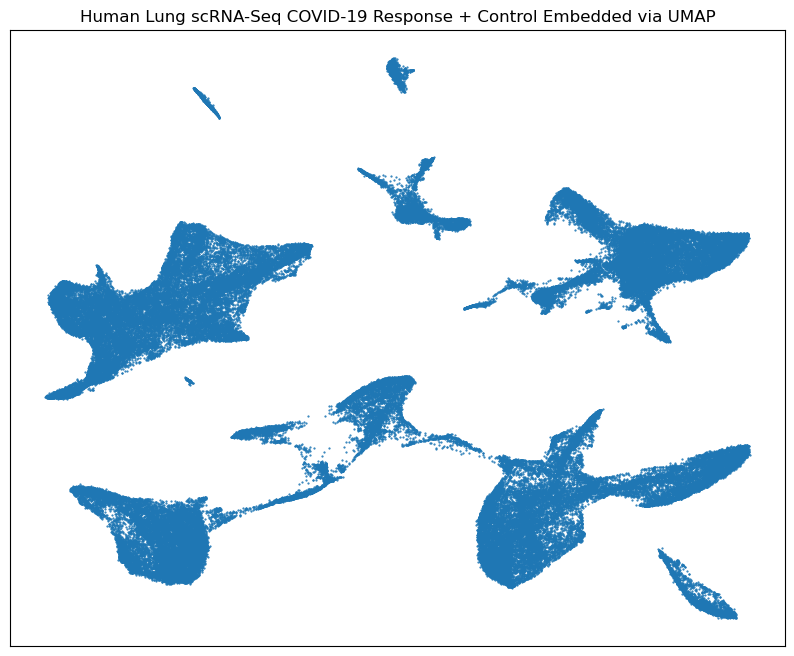

In [7]:
fig, ax = plt.subplots(1, figsize = (10,8))
plt.scatter(*counts_umap.T, s = 0.3, alpha = 1.0)
plt.setp(ax, xticks=[], yticks=[])
plt.title("Human Lung scRNA-Seq COVID-19 Response + Control Embedded via UMAP")
plt.show()

## 3.) Clustering: Compute the K-neighbors graph and cluster the graph with Louvain

In [8]:
# K-neighbors connectivity matrix

counts_neighbors = kneighbors_graph(counts_pca, 50, include_self = True, n_jobs = -1)

In [9]:
# Cluster with Louvain

louvain = Louvain(random_state = 42)
labels = louvain.fit_predict(counts_neighbors)

In [10]:
labels = np.asarray(labels)
print("Number of clusters identified by Louvain:", len(np.unique(labels)))

Number of clusters identified by Louvain: 26


## 4.) View the clusters in a UMAP

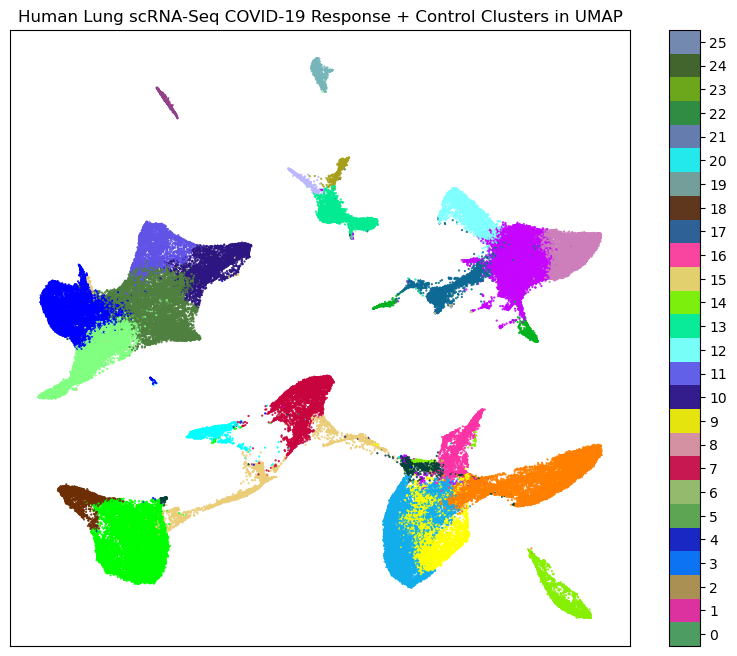

In [11]:
fig, ax = plt.subplots(1, figsize = (10,8))
colormap = np.asarray(distinctipy.get_colors(len(np.unique(labels))))
plt.scatter(*counts_umap.T, s = 0.3, c = colormap[labels])
plt.setp(ax, xticks=[], yticks=[])
cmap = mcolors.LinearSegmentedColormap.from_list("cluster_colormap", colormap)
cmappable = ScalarMappable(norm=None, cmap=cmap)
cbar = plt.colorbar(cmappable, values = np.arange(26))
cbar.set_ticks(np.arange(len(np.unique(labels))))
cbar.set_ticklabels(np.unique(labels))
plt.title("Human Lung scRNA-Seq COVID-19 Response + Control Clusters in UMAP") 
plt.show()

## 5.) Load in the lung metadata, view annotated cell types in UMAP

In [2]:
metadata = pd.read_csv("GSE171524_lung_metaData.txt.gz", sep = '\t', compression = "gzip")
metadata.head()

,NAME,biosample_id,donor_id,species,species__ontology_label,disease,disease__ontology_label,organ,organ__ontology_label,library_preparation_protocol,...,cell_type_intermediate,cell_type_fine,initial_clustering,age,sex,recorded_race,recorded_ethnicity,intubation_days,interval_death_symptoms_onset_days,pmi_h
0,TYPE,group,group,group,group,group,group,group,group,group,...,group,group,group,numeric,group,group,group,numeric,numeric,numeric
1,ATTCACTGTAACAGGC-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN
2,TAACTTCCAACCACGC-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,Macrophages,Alveolar macrophages,3,70,female,White,not_hispanic,NaN,NaN,NaN
3,TTGGGTACACGACAAG-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN
4,AGGCCACAGAGTCACG-1_1,C51ctr,C51ctr,NCBITaxon:9606,Homo sapiens,PATO:0000461,normal,UBERON:0002048,lung,EFO:0009922,...,Airway epithelial cells,Airway ciliated,18,70,female,White,not_hispanic,NaN,NaN,NaN


In [13]:
disease_status = list(metadata['disease__ontology_label'])
cell_type_main = list(metadata['cell_type_main'])
cell_type_intermediate = list(metadata['cell_type_intermediate'])

### 5a) View disease status in the UMAP

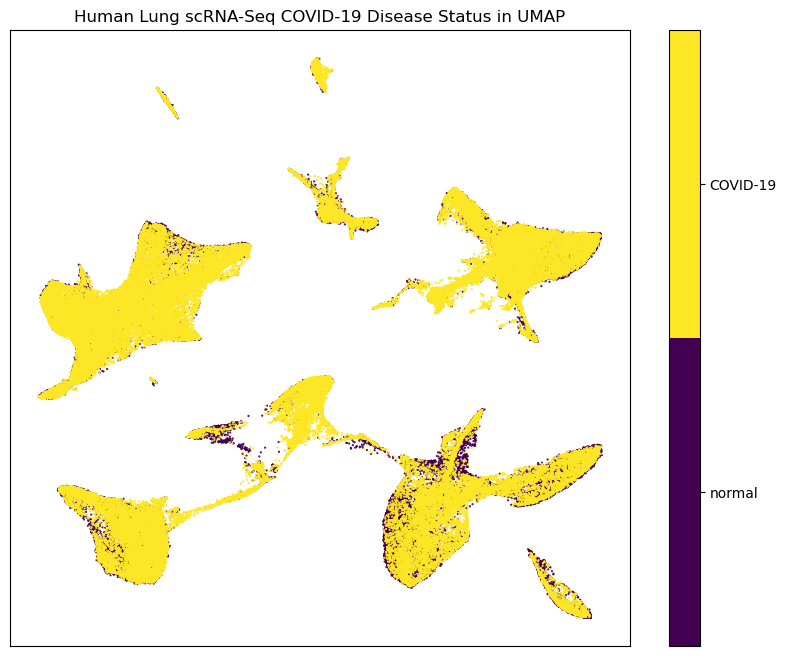

In [14]:
fig, ax = plt.subplots(1, figsize = (10,8))
cdict = {"normal": 0, "COVID-19": 1}
disease_labels = [cdict[i] for i in disease_status]
plt.scatter(*counts_umap.T, s = 0.3, c = disease_labels)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries = np.arange(3)-0.5)
cbar.set_ticks(np.arange(len(np.unique(disease_labels))))
cbar.set_ticklabels(cdict.keys())
plt.title("Human Lung scRNA-Seq COVID-19 Disease Status in UMAP")
plt.show()

### 5b) View the main cell types in the UMAP

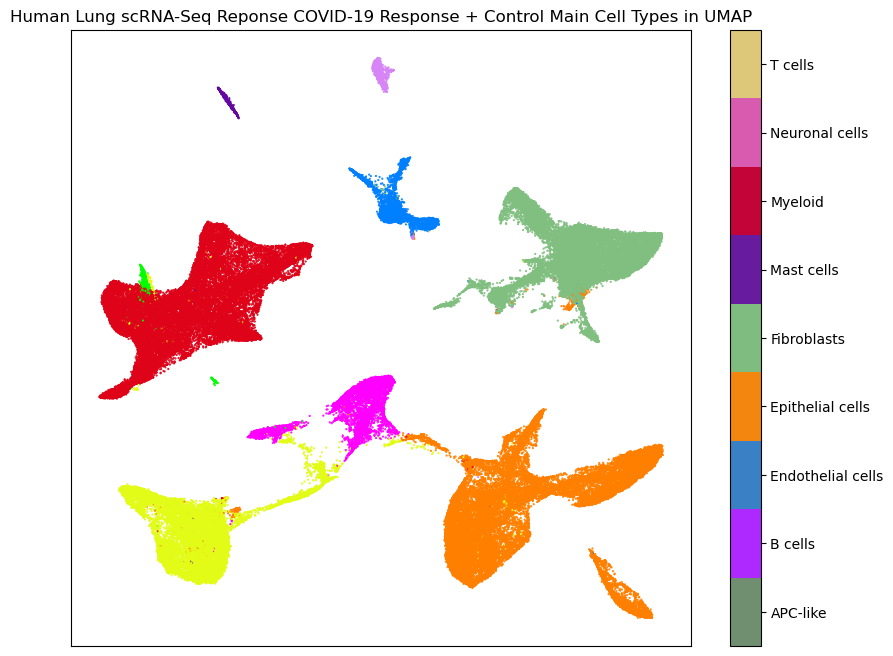

In [15]:
fig, ax = plt.subplots(1, figsize = (10,8))
cdict = {}
i = 0
for cell in np.unique(cell_type_main):
    cdict[cell] = i
    i += 1
cell_labels = [cdict[i] for i in cell_type_main]
colormap = np.asarray(distinctipy.get_colors(len(np.unique(cell_labels))))
plt.scatter(*counts_umap.T, s = 0.3, c = colormap[cell_labels])
plt.setp(ax, xticks=[], yticks=[])
cmap = mcolors.LinearSegmentedColormap.from_list("cell_main_colormap", colormap)
cmappable = ScalarMappable(norm=None, cmap=cmap)
cbar = plt.colorbar(cmappable, values=np.arange(len(cdict)))
cbar.set_ticks(np.arange(len(cdict)))
cbar.set_ticklabels(cdict.keys())
plt.title("Human Lung scRNA-Seq Reponse COVID-19 Response + Control Main Cell Types in UMAP") 
plt.show()

### 5c) View the intermediate cell types in the UMAP

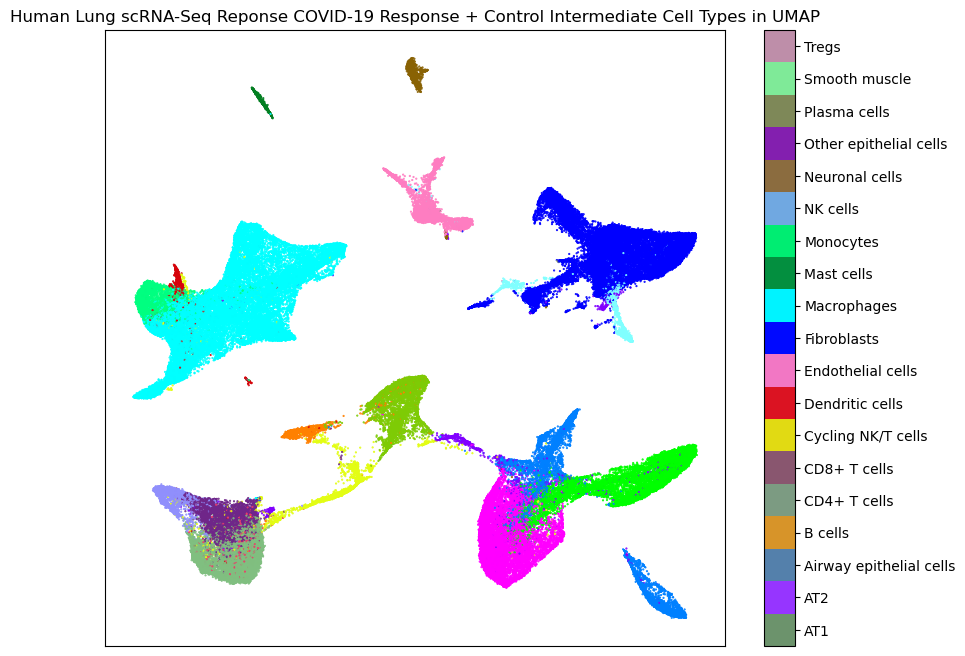

In [16]:
fig, ax = plt.subplots(1, figsize = (10,8))
cdict = {}
i = 0
for cell in np.unique(cell_type_intermediate):
    cdict[cell] = i
    i += 1
cell_labels = [cdict[i] for i in cell_type_intermediate]
colormap = np.asarray(distinctipy.get_colors(len(np.unique(cell_labels))))
plt.scatter(*counts_umap.T, s = 0.3, c = colormap[cell_labels])
plt.setp(ax, xticks=[], yticks=[])
cmap = mcolors.LinearSegmentedColormap.from_list("cell_intermediate_colormap", colormap)
cmappable = ScalarMappable(norm=None, cmap=cmap)
cbar = plt.colorbar(cmappable, values=np.arange(len(cdict)))
cbar.set_ticks(np.arange(len(cdict)))
cbar.set_ticklabels(cdict.keys())
plt.title("Human Lung scRNA-Seq Reponse COVID-19 Response + Control Intermediate Cell Types in UMAP") 
plt.show()